# Basel Index of Consumer Prices
**Project notebook for CAS MAIN, Modul "Deep Learning"**

Christian Moser, Constantin Sluka, April 2022

## Load libraries

In [ ]:
## Load libraries

import numpy as np
import pandas as pd
import random
import requests # need to download data as csv from https://data.bs.ch/explore/dataset/100003/information/ 
from google.colab import drive # need to use google drive to upload the files and download

## Used for ztrans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


## Used for plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import optimizers
from tensorflow.math import confusion_matrix

## Load data
We use the "Export" functionality of the data provided data.bs.ch to dowload the filtered consumer price index data of calendar years 2016 - 2019 (i.e. full four years before the Corona pandemic hit).

We mount GoogleDrive to store our data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Execute the following cell only once...

In [ ]:
## Execute only once!

## Define query to download index data 2009 to 2019 from data.bs.ch as url
url = "https://data.bs.ch/explore/dataset/100003/download/?format=csv&disjunctive.depth=true&q=date:%5B2009-01-01+TO+2019-12-31%5D&timezone=Europe/Berlin&lang=en&use_labels_for_header=true&csv_separator=%3B"
## get url
r = requests.get(url, allow_redirects=True)
## save data to csv on Google drive
with open('/content/drive/My Drive/cas_main_dl/consumerprices10y.csv', 'wb') as cp:
  cp.write(r.content)

Once the data is downloaded to our shared Google Drive directory, we can load it directly:

In [ ]:
## Load data
data = pd.read_csv('/content/drive/My Drive/cas_main_dl/consumerprices10y.csv', delimiter = ';')
print(data.shape)
data.describe()

(160843, 28)


,Erhebungsjahr,Erhebungsmonat,PosNo,Historisches Gewicht,Historische Tiefe der Warenkorb-Hierarchie,Sortierreihenfolge,Gewicht aktuell,Tiefencode,Indexwert,Indexwert Vormonat,Indexwert Vorjahr,Monatsteuerung,Jahresteuerung,relWeight
count,160843.000000,160843.000000,160843.000000,160843.000000,160843.000000,151470.000000,151470.000000,151470.000000,160843.000000,67831.000000,66245.000000,67831.000000,66245.000000,160843.000000
mean,2015.046486,6.500127,5364.869382,0.388104,4.538954,819.397511,0.405130,5.054077,42.351413,100.218293,100.306978,0.029718,0.166385,9.679853
std,2.782251,3.451990,3773.799480,3.218482,0.911704,477.063634,3.338021,1.400714,50.446493,15.127939,17.679464,2.854779,6.363019,45.274127
min,2009.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,42.253500,42.253500,-100.000000,-100.000000,0.000000
25%,2013.000000,4.000000,1502.000000,0.000000,4.000000,411.000000,0.000000,4.000000,0.000000,94.540700,93.800300,-0.059700,-0.840400,0.000000
50%,2015.000000,7.000000,5004.000000,0.000000,5.000000,798.000000,0.000000,5.000000,0.000000,98.861100,98.522400,0.000000,0.148800,0.000000
75%,2017.000000,10.000000,9218.000000,0.071000,5.000000,1234.000000,0.087000,6.000000,97.587950,102.526900,103.081900,0.128900,1.647900,3.665000
max,2019.000000,12.000000,12555.000000,100.000000,8.000000,1657.000000,100.000000,8.000000,424.461000,428.630600,517.507000,102.857000,102.857000,2687.755000


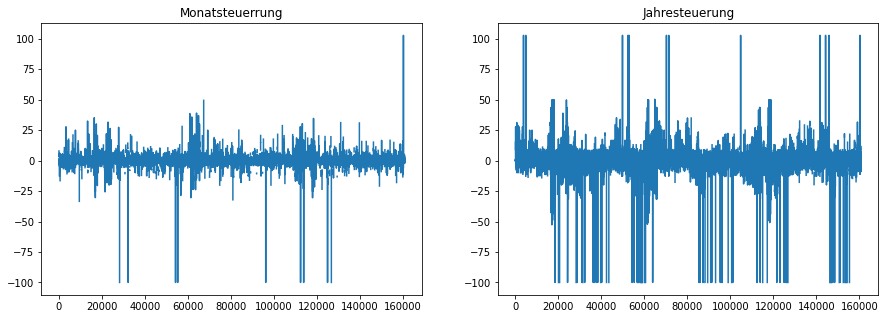

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,(1))
plt.plot(data['Monatsteuerung'])
plt.title('Monatsteuerrung')
plt.subplot(1,2,(2))
plt.plot(data['Jahresteuerung'])
plt.title('Jahresteuerung')
plt.show()

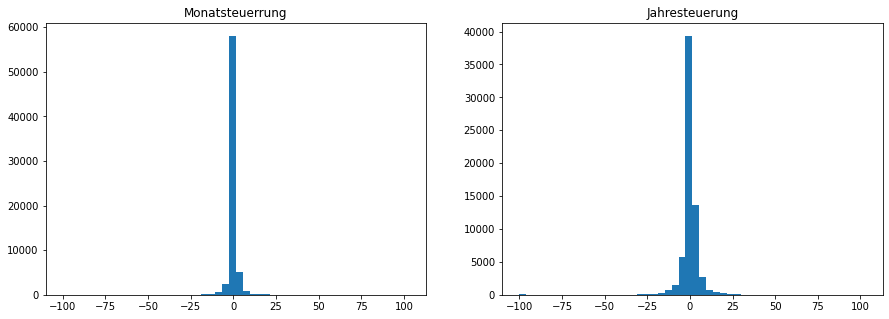

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,(1))
plt.hist(data['Monatsteuerung'], bins = 50)
plt.title('Monatsteuerrung')
plt.subplot(1,2,(2))
plt.hist(data['Jahresteuerung'], bins = 50)
plt.title('Jahresteuerung')
plt.show()

We need to remove all "historic" products ("Gewicht aktuell" == 0)

In [ ]:
data = data[data['Gewicht aktuell'] != 0]
data.shape

(55297, 28)

### Hauptgruppe
Check the variable "Hauptgruppe"

In [ ]:
pd.unique(data['Hauptgruppe'])

array(['Nahrungsmittel und alkoholfreie Getränke',
       'Alkoholische Getränke und Tabak', 'Bekleidung und Schuhe',
       'Wohnen und Energie', 'Hausrat und laufende Haushaltsführung',
       'Gesundheitspflege', 'Verkehr', 'Nachrichtenübermittlung',
       'Freizeit und Kultur', 'Unterricht', 'Restaurants und Hotels',
       'Sonstige Waren und Dienstleistungen', nan,
       'Erziehung und Unterricht', 'Hausrat und laufende Haushaltführung',
       'Wohnungsmiete und Energie'], dtype=object)

Duplicates, clean!

In [ ]:
data.loc[data['Hauptgruppe'] == 'Wohnungsmiete und Energie', 'Hauptgruppe'] = 'Wohnen und Energie'
data.loc[data['Hauptgruppe'] == 'Erziehung und Unterricht', 'Hauptgruppe'] = 'Unterricht'
data.loc[data['Hauptgruppe'] == 'Hausrat und laufende Haushaltführung', 'Hauptgruppe'] = 'Hausrat und laufende Haushaltsführung'
nhauptgruppe = len(pd.unique(data['Hauptgruppe'])) - 1 # without nan
pd.unique(data['Hauptgruppe'])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


array(['Nahrungsmittel und alkoholfreie Getränke',
       'Alkoholische Getränke und Tabak', 'Bekleidung und Schuhe',
       'Wohnen und Energie', 'Hausrat und laufende Haushaltsführung',
       'Gesundheitspflege', 'Verkehr', 'Nachrichtenübermittlung',
       'Freizeit und Kultur', 'Unterricht', 'Restaurants und Hotels',
       'Sonstige Waren und Dienstleistungen', nan], dtype=object)

### Time information
Gemäss Oliver würde man den Monat, falls man den als Input-feature verwenden wollte, über eine sinus oder cosinus-Funktion so transformieren, dass 1 (Januar) nicht maximal weit von 12 (Dezember) entfernt ist.
Dies kann man machen mit folgender Zeile:

X['monthcos'] = np.cos((X['Erhebungsmonat'].astype(float))/12.0 *2.0* np.pi)

oder vereinfacht 
X['monthcos'] = np.cos((X['Erhebungsmonat'].astype(float))/6.0 * np.pi)

bin aber noch nicht sicher, ob wir den Monat benötigen als inputfeature

In [ ]:
# Convert month to float
data['monthcos'] = np.cos((data['Erhebungsmonat'].astype(float))/12.0 * 2.0 * np.pi)
data.shape

(55297, 29)

## Create training, validation, and test data

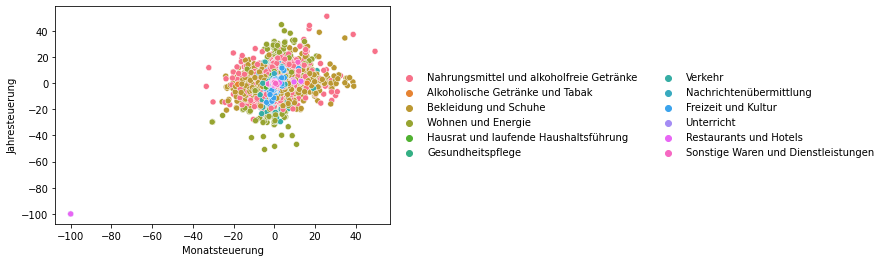

In [ ]:
ax = sns.scatterplot(x="Monatsteuerung", y="Jahresteuerung", hue="Hauptgruppe", data=data)
sns.move_legend(
    ax, "center left",
    bbox_to_anchor=(1, 0.5), ncol=2, title=None, frameon=False
)



Apparently one product was removed from the index (price dropped to 0). Remove



In [ ]:
data = data[data['Monatsteuerung'] > - 100]
data.shape

(47770, 28)

In [ ]:
print(len(data[np.isnan(data['Monatsteuerung'])]))
print(len(data[np.isnan(data['Jahresteuerung'])]))

0
1056


There are > 1000 observations without data on annual inflation (Possibly because of removed products). Remove for now, but think of clever way to impute if possible

In [ ]:
data = data[~ np.isnan(data['Jahresteuerung'])]
data.shape

(46714, 28)

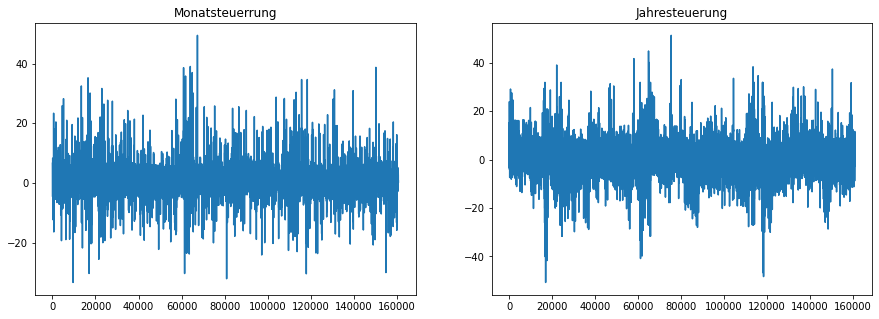

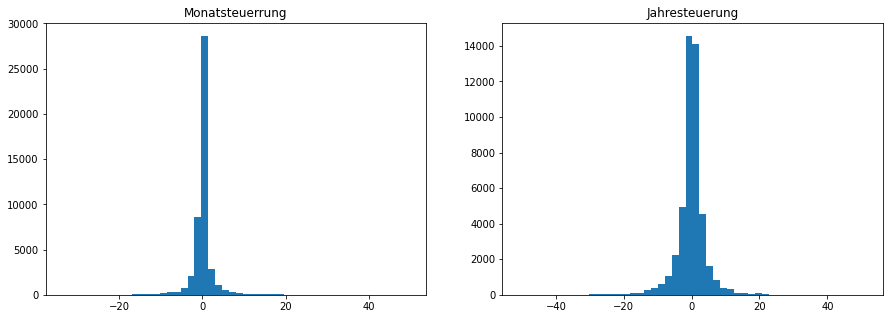

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,(1))
plt.plot(data['Monatsteuerung'])
plt.title('Monatsteuerrung')
plt.subplot(1,2,(2))
plt.plot(data['Jahresteuerung'])
plt.title('Jahresteuerung')
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,(1))
plt.hist(data['Monatsteuerung'], bins = 50)
plt.title('Monatsteuerrung')
plt.subplot(1,2,(2))
plt.hist(data['Jahresteuerung'], bins = 50)
plt.title('Jahresteuerung')
plt.show()

In [ ]:
# Perform Standardization using ztrans
std_scale_Mt = preprocessing.StandardScaler().fit(np.asarray(data['Monatsteuerung']).reshape(-1,1))
std_scale_Jt = preprocessing.StandardScaler().fit(np.asarray(data['Jahresteuerung']).reshape(-1,1))

data['Monatsteuerung_std'] = std_scale_Mt.transform(np.asarray(data['Monatsteuerung']).reshape(-1,1))
data['Jahresteuerung_std'] = std_scale_Mt.transform(np.asarray(data['Jahresteuerung']).reshape(-1,1))

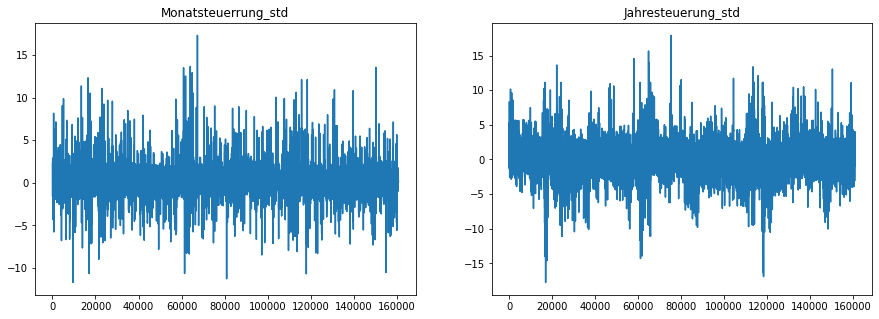

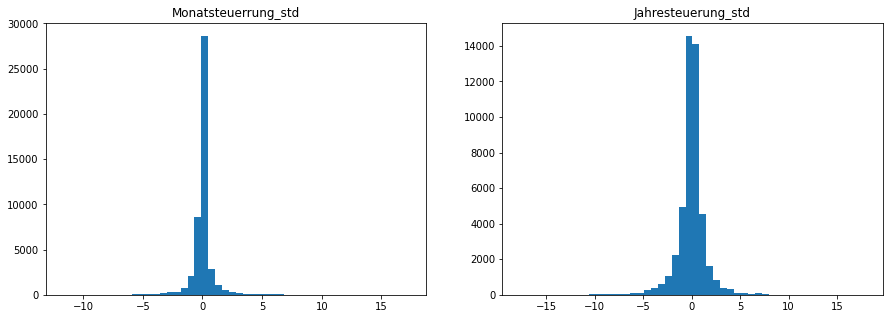

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,(1))
plt.plot(data['Monatsteuerung_std'])
plt.title('Monatsteuerrung_std')
plt.subplot(1,2,(2))
plt.plot(data['Jahresteuerung_std'])
plt.title('Jahresteuerung_std')
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,(1))
plt.hist(data['Monatsteuerung_std'], bins = 50)
plt.title('Monatsteuerrung_std')
plt.subplot(1,2,(2))
plt.hist(data['Jahresteuerung_std'], bins = 50)
plt.title('Jahresteuerung_std')
plt.show()

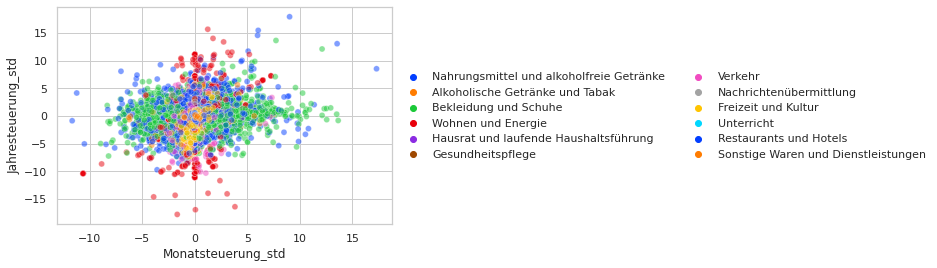

In [ ]:
#sns.set(rc = {'figure.figsize':(15,8)}, 'figure.facecolor':'cornflowerblue'})
sns.set_theme(style="whitegrid")
ax = sns.scatterplot(x="Monatsteuerung_std", y="Jahresteuerung_std", hue="Hauptgruppe", data=data, palette = sns.color_palette("bright", nhauptgruppe), alpha = .5)
sns.move_legend(
    ax, "center left",
    bbox_to_anchor=(1, 0.5), ncol=2, title=None, frameon=False
)

Split data into train, validation, and test data sets with 70%, 15%, 15%

Randomly sample among the set of products (i.e. all data of a product belong to same group)

In [ ]:
products = pd.unique(data["PosNo"])
print("Total number of products: ",len(products),"\n")

## Set random seed and shuffle list of unique products
random.seed(42)
random.shuffle(products)

## Use random order of products to define train, val, and test data
data.index = data['PosNo']

## 70% and 85% of products
products70 = int(len(products)//(100/70))
products85 = int(len(products)//(100/85))

## Split
dtrain = data.loc[products[0:products70]]
dval = data.loc[products[products70:products85]]
dtest = data.loc[products[products85:]]

print("nr of traning samples = ",len(dtrain))
print("nr of validation samples = ",len(dval))
print("nr of test samples = ",len(dtest))

print("\nNumber of products in training: ",len(pd.unique(dtrain['PosNo'])))
print("Number of products in validation: ",len(pd.unique(dval['PosNo'])))
print("Number of products in test: ",len(pd.unique(dtest['PosNo'])))

Total number of products:  430 

nr of traning samples =  32688
nr of validation samples =  6898
nr of test samples =  7128

Number of products in training:  300
Number of products in validation:  65
Number of products in test:  65


In [ ]:
data.groupby('Hauptgruppe').PosNo.nunique()

Hauptgruppe
Alkoholische Getränke und Tabak             20
Bekleidung und Schuhe                       41
Freizeit und Kultur                         62
Gesundheitspflege                           18
Hausrat und laufende Haushaltsführung       39
Nachrichtenübermittlung                     13
Nahrungsmittel und alkoholfreie Getränke    97
Restaurants und Hotels                      31
Sonstige Waren und Dienstleistungen         31
Unterricht                                   9
Verkehr                                     27
Wohnen und Energie                          41
Name: PosNo, dtype: int64

## One-Hot Encoding of dependent variable

In [ ]:
def SeriesToCategorical(ydata, ngroups):
  # Factorize to get integer: (integer index, Hauptgruppe)
  Yf = ydata.factorize(sort = True)[0] # Sort = True to sort Hauptrguppe alphabetically
  # Create one-hot encoding
  Ycat = to_categorical(Yf, ngroups)
  return Ycat

In [ ]:
Ytrain = SeriesToCategorical(dtrain["Hauptgruppe"], nhauptgruppe)
Yval = SeriesToCategorical(dval["Hauptgruppe"], nhauptgruppe)
Ytest = SeriesToCategorical(dtest["Hauptgruppe"], nhauptgruppe)

## Convert data frame of predictor variables to tensor

In [ ]:
def PandasToArray(xdata):
  return np.asarray(xdata)

In [ ]:
# Uses standardized variables
Xtrain = PandasToArray(dtrain[['Monatsteuerung_std','Jahresteuerung_std','monthcos']])
Xval = PandasToArray(dval[['Monatsteuerung_std','Jahresteuerung_std','monthcos']])
Xtest = PandasToArray(dtest[['Monatsteuerung_std','Jahresteuerung_std','monthcos']])

## Define a baseline

### First, a simple logistic regression...

In [ ]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(solver='liblinear').fit(Xtrain, dtrain["Hauptgruppe"].factorize(sort = True)[0])
print(LR_model.score(Xtrain, dtrain["Hauptgruppe"].factorize(sort = True)[0]))
print(LR_model.score(Xval, dval["Hauptgruppe"].factorize(sort = True)[0]))

0.24091409691629956
0.28718469121484486


### ... versus random Guessing

In [ ]:
random.seed(42)
Yrandom = random.choices(range(nhauptgruppe), k = len(Xtrain))
sum(Yrandom == dtrain["Hauptgruppe"].factorize(sort = True)[0])/len(Xtrain)

0.0827826725403818

### ... versus a kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
ktrain_acc = []
kval_acc = []
for kn in range(3,50):
  Kneigh = KNeighborsClassifier(n_neighbors=kn)
  Kneigh.fit(Xtrain, dtrain["Hauptgruppe"].factorize(sort = True)[0])
  ktrain_acc.append(Kneigh.score(Xtrain, dtrain["Hauptgruppe"].factorize(sort = True)[0]))
  kval_acc.append(Kneigh.score(Xval, dval["Hauptgruppe"].factorize(sort = True)[0]))

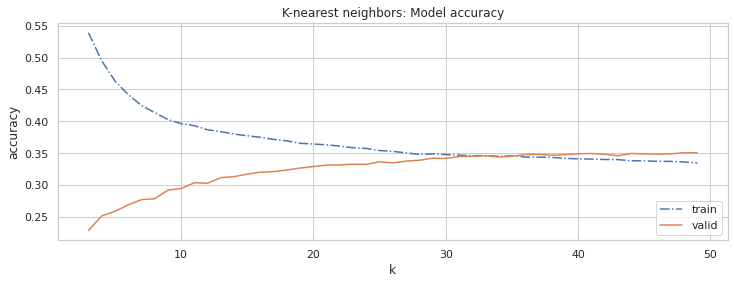

In [ ]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.plot(range(3,50),ktrain_acc,linestyle='-.')
plt.plot(range(3,50),kval_acc)
plt.title('K-nearest neighbors: Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('k')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

In [ ]:
print(len(kval_acc))
print(kval_acc[0], kval_acc[7], kval_acc[46])

47
0.2289069295447956 0.2947231081472891 0.35053638735865467


## Definition of NN

In [ ]:
## Check tensor shape
Xtrain.shape, Ytrain.shape

((32688, 3), (32688, 12))

In [ ]:
# Definition of the network
model = Sequential()
model.add(Dense(27, batch_input_shape = (None, 3), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(54, activation='sigmoid'))
model.add(Dropout(0.3))
#model.add(Dense(54, activation='sigmoid'))
#model.add(Dropout(0.3))
model.add(Dense(12, activation='softmax'))

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
# summarize the architecture of the NN along with the number of weights
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 27)                108       
                                                                 
 dropout_17 (Dropout)        (None, 27)                0         
                                                                 
 dense_37 (Dense)            (None, 54)                1512      
                                                                 
 dropout_18 (Dropout)        (None, 54)                0         
                                                                 
 dense_38 (Dense)            (None, 12)                660       
                                                                 
Total params: 2,280
Trainable params: 2,280
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training of the network
history = model.fit(Xtrain, Ytrain,
          epochs=400,              
          batch_size=128,
          shuffle = True,
          validation_data=(Xval, Yval),
          verbose=1)

Epoch 1/400
256/256 [==============================] - 1s 3ms/step - loss: 2.3610 - accuracy: 0.1906 - val_loss: 2.1747 - val_accuracy: 0.2911
Epoch 2/400
256/256 [==============================] - 1s 3ms/step - loss: 2.2563 - accuracy: 0.2327 - val_loss: 2.1359 - val_accuracy: 0.3073
Epoch 3/400
256/256 [==============================] - 1s 3ms/step - loss: 2.2198 - accuracy: 0.2411 - val_loss: 2.1145 - val_accuracy: 0.3092
Epoch 4/400
256/256 [==============================] - 1s 3ms/step - loss: 2.1880 - accuracy: 0.2503 - val_loss: 2.0968 - val_accuracy: 0.3069
Epoch 5/400
256/256 [==============================] - 1s 3ms/step - loss: 2.1692 - accuracy: 0.2569 - val_loss: 2.0747 - val_accuracy: 0.3097
Epoch 6/400
256/256 [==============================] - 1s 3ms/step - loss: 2.1508 - accuracy: 0.2613 - val_loss: 2.0751 - val_accuracy: 0.3643
Epoch 7/400
256/256 [==============================] - 1s 3ms/step - loss: 2.1367 - accuracy: 0.2675 - val_loss: 2.0575 - val_accuracy: 0.3607

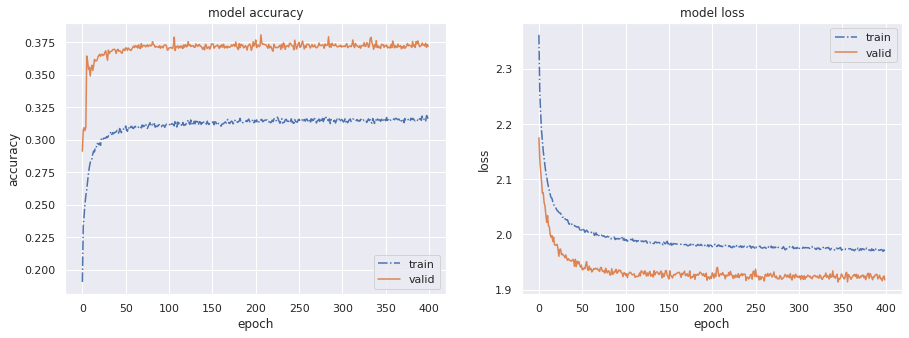

In [ ]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(15,5))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

tf.Tensor(
[[   0    1    0    0    0    0   35    0    0    0    0    0]
 [   0  240   45    0    0    0  435    1    0    0    0   71]
 [   0   35  204    0    0    1  581   20    0    0    0  443]
 [   0    6   19    0    0    0   11    0    0    0    0  132]
 [   0    7   20    0    0    0  269    2    0    0    0    2]
 [   0    5  105    0    0    0   91    1    0    0    0   38]
 [   0   94   54    0    1    0 1795    5    0    0    0    7]
 [   0   20    7    0    0    3  367   13    0    0    0   92]
 [   0   19   57    0    0    4  285    1    0    0    0  186]
 [   0    0    2    0    0    0   32    0    0    0    0  230]
 [   0    6   37    0    0    2  226    0    0    0    0   29]
 [   0    0   38    0    0    0  135   18    0    0    0  313]], shape=(12, 12), dtype=int32)


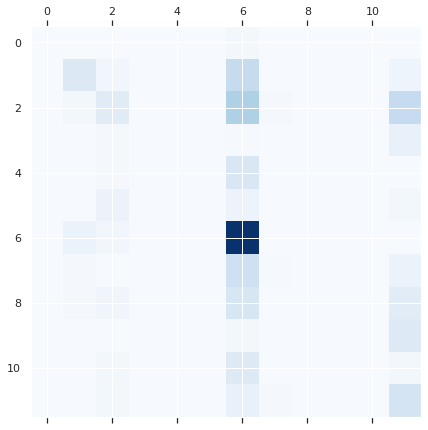

In [ ]:
pred=model.predict(Xval)
mconfuse=confusion_matrix(np.argmax(Yval,axis=1), np.argmax(pred,axis=1))
plt.matshow(mconfuse, cmap=plt.cm.Blues, alpha=2)
print(mconfuse)

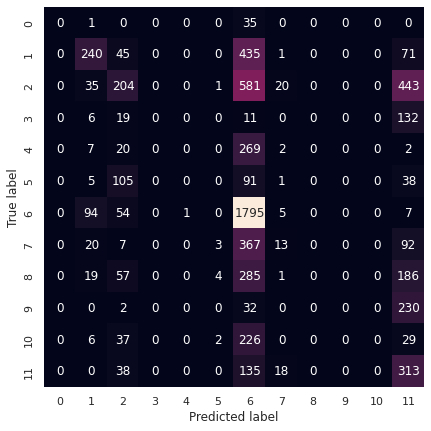

In [ ]:
sns.set(rc = {'figure.figsize':(7,7)})
sns.heatmap(mconfuse, square = True, annot = True, fmt='d', cbar = False)
plt.xlabel('Predicted label')
plt.ylabel('True label');

In [ ]:
### Doesn't work
from sklearn.cluster import KMeans
Km = KMeans(n_clusters=nhauptgruppe, random_state=0)
Km.fit(Xtrain, dtrain["Hauptgruppe"].factorize()[0])
print(Km.score(Xtrain, dtrain["Hauptgruppe"].factorize()[0]))
print(Km.score(Xval, dval["Hauptgruppe"].factorize()[0]))

-154896.2720060741
-39302.051538240856


## Why did it not work?
Probably because of correlation!

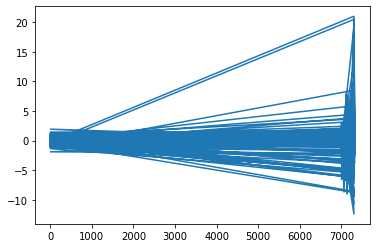

In [ ]:
## ToDo...
Traffic = pd.Series(data.loc[data['Hauptgruppe'] == 'Verkehr', 'Monatsteuerung'])
Energy = pd.Series(data.loc[data['Hauptgruppe'] == 'Wohnen und Energie', 'Monatsteuerung'])
ax = sns.scatterplot(x="", y="Jahresteuerung", hue="Hauptgruppe", data=data, palette = sns.color_palette("bright", nhauptgruppe), alpha = .5)

# Try with energy vs food

Hauptgruppe
Alkoholische Getränke und Tabak             20
Bekleidung und Schuhe                       41
Freizeit und Kultur                         62
Gesundheitspflege                           18
Hausrat und laufende Haushaltsführung       39
Nachrichtenübermittlung                     13
Nahrungsmittel und alkoholfreie Getränke    97
Restaurants und Hotels                      31
Sonstige Waren und Dienstleistungen         31
Unterricht                                   9
Verkehr                                     27
Wohnen und Energie                          41

Text(0, 0.5, 'Jahresteuerung')

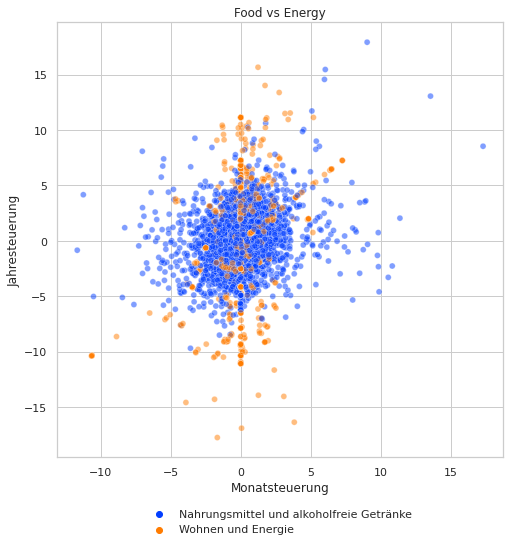

In [ ]:
#data2 = data[(data['Hauptgruppe'] == 'Restaurants und Hotels') | (data['Hauptgruppe'] == 'Verkehr')]
data2 = data[(data['Hauptgruppe'] == 'Wohnen und Energie') | (data['Hauptgruppe'] == 'Nahrungsmittel und alkoholfreie Getränke')]
sns.set(rc = {'figure.figsize':(8,8)})
sns.set_theme(style="whitegrid")
ax = sns.scatterplot(x="Monatsteuerung_std", y="Jahresteuerung_std", hue="Hauptgruppe", data=data2, palette = sns.color_palette("bright", 2), alpha = .5)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(0.5, -0.2), ncol=1, title=None, frameon=False
)
plt.title('Food vs Energy')
# Set x-axis label
plt.xlabel('Monatsteuerung')
# Set y-axis label
plt.ylabel('Jahresteuerung')

In [ ]:
products = pd.unique(data2["PosNo"])
print("Total number of products: ",len(products),"\n")

## Set random seed and shuffle list of unique products
random.seed(42)
random.shuffle(products)

## Use random order of products to define train, val, and test data
data2.index = data2['PosNo']

## 70% and 85% of products
products70 = int(len(products)//(100/70))
products85 = int(len(products)//(100/85))

## Split
dtrain2 = data2.loc[products[0:products70]]
dval2 = data2.loc[products[products70:products85]]
dtest2 = data2.loc[products[products85:]]

print("nr of traning samples = ",len(dtrain2))
print("nr of validation samples = ",len(dval2))
print("nr of test samples = ",len(dtest2))

print("\nNumber of products in training: ",len(pd.unique(dtrain2['PosNo'])))
print("Number of products in validation: ",len(pd.unique(dval2['PosNo'])))
print("Number of products in test: ",len(pd.unique(dtest2['PosNo'])))

Total number of products:  138 

nr of traning samples =  10812
nr of validation samples =  2148
nr of test samples =  2448

Number of products in training:  96
Number of products in validation:  21
Number of products in test:  21


In [ ]:
Ytrain2 = SeriesToCategorical(dtrain2["Hauptgruppe"], 2)
Yval2 = SeriesToCategorical(dval2["Hauptgruppe"], 2)
Ytest2 = SeriesToCategorical(dtest2["Hauptgruppe"], 2)

In [ ]:
Xtrain2 = PandasToArray(dtrain2[['Monatsteuerung','Jahresteuerung']])
Xval2 = PandasToArray(dval2[['Monatsteuerung','Jahresteuerung']])
Xtest2 = PandasToArray(dtest2[['Monatsteuerung','Jahresteuerung']])

In [ ]:
Xtrain2.shape, Ytrain2.shape

((10812, 2), (10812, 2))

In [ ]:
# Definition of the network
model = Sequential()
model.add(Dense(10, batch_input_shape = (None, 2), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))


model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
# summarize the architecture of the NN along with the number of weights
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 10)                30        
                                                                 
 dropout_6 (Dropout)         (None, 10)                0         
                                                                 
 dense_9 (Dense)             (None, 24)                264       
                                                                 
 dropout_7 (Dropout)         (None, 24)                0         
                                                                 
 dense_10 (Dense)            (None, 24)                600       
                                                                 
 dropout_8 (Dropout)         (None, 24)                0         
                                                                 
 dense_11 (Dense)            (None, 2)                

In [ ]:
# Training of the network
history = model.fit(Xtrain2, Ytrain2,
          epochs=400,              
          batch_size=128,
          shuffle = True,
          validation_data=(Xval2, Yval2),
          verbose=1)

Epoch 1/400
85/85 [==============================] - 1s 5ms/step - loss: 0.6863 - accuracy: 0.6899 - val_loss: 0.5693 - val_accuracy: 0.7374
Epoch 2/400
85/85 [==============================] - 0s 3ms/step - loss: 0.6136 - accuracy: 0.7247 - val_loss: 0.5455 - val_accuracy: 0.7374
Epoch 3/400
85/85 [==============================] - 0s 3ms/step - loss: 0.5852 - accuracy: 0.7353 - val_loss: 0.5344 - val_accuracy: 0.7467
Epoch 4/400
85/85 [==============================] - 0s 3ms/step - loss: 0.5754 - accuracy: 0.7358 - val_loss: 0.5264 - val_accuracy: 0.7444
Epoch 5/400
85/85 [==============================] - 0s 3ms/step - loss: 0.5551 - accuracy: 0.7395 - val_loss: 0.5159 - val_accuracy: 0.7388
Epoch 6/400
85/85 [==============================] - 0s 3ms/step - loss: 0.5419 - accuracy: 0.7437 - val_loss: 0.4971 - val_accuracy: 0.7426
Epoch 7/400
85/85 [==============================] - 0s 3ms/step - loss: 0.5315 - accuracy: 0.7479 - val_loss: 0.4791 - val_accuracy: 0.7426
Epoch 8/400
8

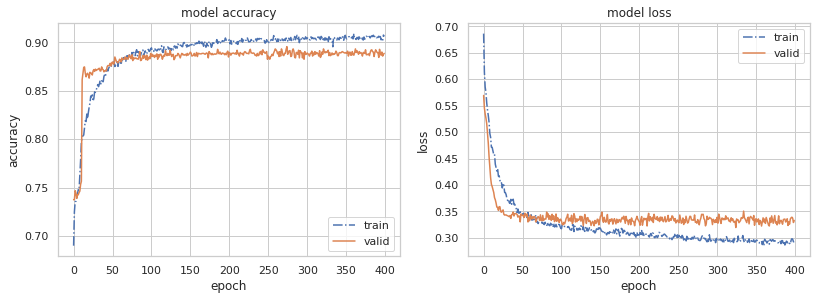

In [ ]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [ ]:
pred2=model.predict(Xval2)
print(confusion_matrix(np.argmax(Yval2,axis=1),
                       np.argmax(pred2,axis=1)))

tf.Tensor(
[[1523   61]
 [ 178  386]], shape=(2, 2), dtype=int32)


tf.Tensor(
[[1523   61]
 [ 178  386]], shape=(2, 2), dtype=int32)


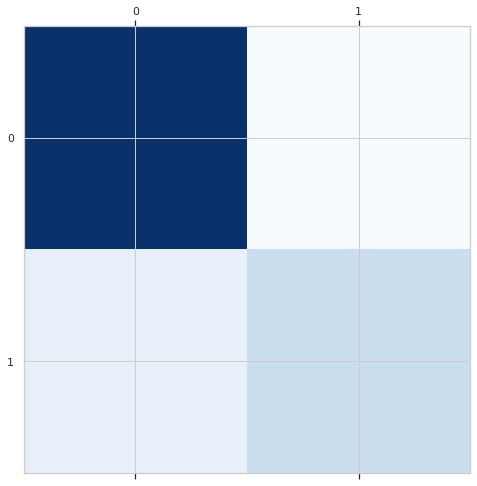

In [ ]:
pred=model.predict(Xval2)
mconfuse=confusion_matrix(np.argmax(Yval2,axis=1), np.argmax(pred,axis=1))
plt.matshow(mconfuse, cmap=plt.cm.Blues, alpha=2)
print(mconfuse)

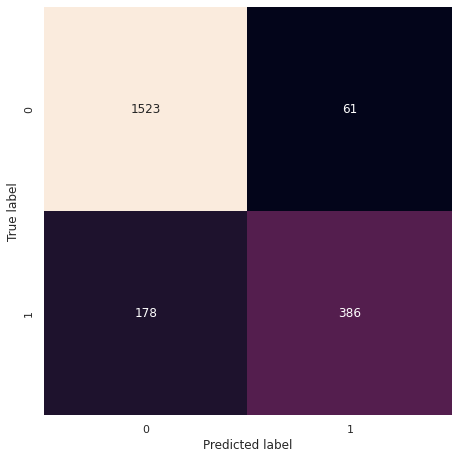

In [ ]:
sns.set(rc = {'figure.figsize':(7,7)})
sns.heatmap(mconfuse, square = True, annot = True, fmt='d', cbar = False)
plt.xlabel('Predicted label')
plt.ylabel('True label');

(225, 1, 2)


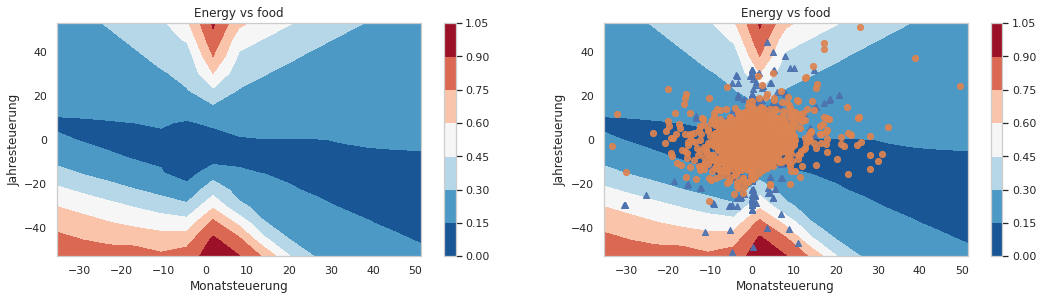

In [ ]:
## Copied from https://colab.research.google.com/github/tensorchiefs/dl_course_2022/blob/master/notebooks/02_fcnn_with_banknote_sol.ipynb#scrollTo=DrWqT9T2oStj
def plotModel(X,Y, model, t):
    # define a grid for the 2D feature space
    # predict at each grid point the probability for class 1

    x1list = np.linspace(np.min(X[:,0])-2, np.max(X[:,0])+2, 15) # Define 100 points on the x-axis
    x2list = np.linspace(np.min(X[:,1])-2, np.max(X[:,1])+2, 15) # Define 100 points on the x-axis
    X1_grid, X2_grid = np.meshgrid(x1list, x2list)

    # model.predict for respective value x1 and x2 
    p = np.array([model.predict(np.reshape(np.array([l1,l2]),(1,2))) for l1,l2 in zip(np.ravel(X1_grid), np.ravel(X2_grid))])
    print(p.shape)
    if len(p.shape) == 3 and p.shape[2]==2:
        p = p[:,:,1] # pick p for class 1 if there are more than 2 classes
    p = np.reshape(p,X1_grid.shape)

    # visualize the predicted probabilities in the 2D feature space
    # once without and once with the data points used for fitting
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,(1))
    cp = plt.contourf(X1_grid, X2_grid, p,cmap='RdBu_r')
    plt.colorbar(cp)
    plt.title(t)
    plt.xlabel('Monatsteuerung')
    plt.ylabel('Jahresteuerung')
    
    plt.subplot(1,2,(2))
    cp = plt.contourf(X1_grid, X2_grid, p,cmap='RdBu_r')
    plt.colorbar(cp)
    idx_f = [np.where(Y==[1,0])]
    idx_r = [np.where(Y==[0,1])]
    plt.scatter(X[idx_r,0],X[idx_r,1], alpha=0.7,marker='^')
    plt.scatter(X[idx_f,0],X[idx_f,1], alpha=0.7,marker='o')
    plt.title(t)
    plt.xlabel('Monatsteuerung')
    plt.ylabel('Jahresteuerung')
    
plotModel(Xtrain2, Ytrain2, model, 'Energy vs food')

In [ ]:
Ytrain2[0]

array([0., 1.], dtype=float32)

In [ ]:
## Compare with logistic regression
LR_model = LogisticRegression(solver='liblinear').fit(Xtrain2, dtrain2["Hauptgruppe"].factorize(sort = True)[0])
print(LR_model.score(Xtrain2, dtrain2["Hauptgruppe"].factorize(sort = True)[0]))
print(LR_model.score(Xval2, dval2["Hauptgruppe"].factorize(sort = True)[0]))

0.7375138734739178
0.7355679702048417


In [ ]:
random.seed(21)
Yrandom = random.choices(range(2), k = len(Xtrain2))
sum(Yrandom == dtrain2["Hauptgruppe"].factorize(sort = True)[0])/len(Xtrain2)

0.4982426933037366

In [ ]:
ktrain2_acc = []
kval2_acc = []
for kn in range(3,50):
  Kneigh = KNeighborsClassifier(n_neighbors=kn)
  Kneigh.fit(Xtrain2, dtrain2["Hauptgruppe"].factorize(sort = True)[0])
  ktrain2_acc.append(Kneigh.score(Xtrain2, dtrain2["Hauptgruppe"].factorize(sort = True)[0]))
  kval2_acc.append(Kneigh.score(Xval2, dval2["Hauptgruppe"].factorize(sort = True)[0]))

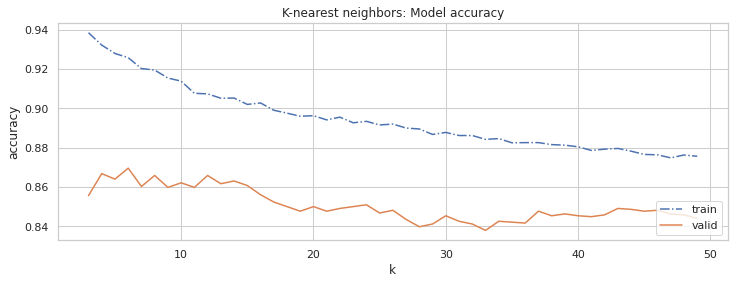

In [ ]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.plot(range(3,50),ktrain2_acc,linestyle='-.')
plt.plot(range(3,50),kval2_acc)
plt.title('K-nearest neighbors: Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('k')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

In [ ]:
print(kval2_acc[0], kval2_acc[7], kval2_acc[36], kval2_acc[46])

0.8556797020484171 0.8621973929236499 0.8463687150837989 0.8440409683426443


#3rd Attempt

Switch from inputfeature p=2 (Monatsteuerung, Jahresteuerung) to Indexteuerung, but pivot data so p=132 (11x 12 months). This reduces N to 430. 

In [ ]:
# check for NaN
print(len(data[np.isnan(data['Indexwert'])]))

0


In [ ]:
# remove duplicates, (Hauptgruppe, PosNo, Erhebungsdatum)
tmp3a=data.drop_duplicates(['Hauptgruppe','PosNo','Erhebungsdatum'])[['Hauptgruppe','PosNo','Erhebungsdatum','Indexwert']]

In [ ]:
#pivot data to get features in a row
tmp3b = tmp3a.pivot(index=['Hauptgruppe','PosNo'], columns='Erhebungsdatum', values='Indexwert').add_prefix('MT').reset_index().set_index('PosNo')
tmp3b.shape

(430, 133)

In [ ]:
# remove all Series with gaps
tmp3c = tmp3b.dropna(axis=0)
tmp3c.shape

(315, 133)

In [ ]:
pd.unique(tmp3c['Hauptgruppe'])

array(['Alkoholische Getränke und Tabak', 'Bekleidung und Schuhe',
       'Freizeit und Kultur', 'Gesundheitspflege',
       'Hausrat und laufende Haushaltsführung', 'Nachrichtenübermittlung',
       'Nahrungsmittel und alkoholfreie Getränke',
       'Restaurants und Hotels', 'Sonstige Waren und Dienstleistungen',
       'Unterricht', 'Verkehr', 'Wohnen und Energie'], dtype=object)

In [ ]:
nhauptgruppe = len(pd.unique(tmp3c['Hauptgruppe']))
nhauptgruppe

12

In [ ]:
#to delete
def SeriesToCategorical(ydata, ngroups):
  # Factorize to get integer: (integer index, Hauptgruppe)
  Yf = ydata.factorize(sort = True)[0] # Sort = True to sort Hauptrguppe alphabetically
  # Create one-hot encoding
  Ycat = to_categorical(Yf, ngroups)
  return Ycat

In [ ]:
Y3 = SeriesToCategorical(tmp3c["Hauptgruppe"], nhauptgruppe)

In [ ]:
#check remaining length of Data
print('Remaining data: ', len(Y3))

#Remove Hauptgruppe from Data
tmp3d = tmp3c.drop(['Hauptgruppe'], axis=1)

Remaining data:  315


In [ ]:
# create Train, Validation and test-samples
# Train/Test first
X_train, Xtest3, y_train, ytest3 = train_test_split(tmp3d, Y3, test_size=0.15, random_state=0)
#Train/Validation subsequently
Xtrain3, Xval3, ytrain3, yval3 = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=0)

In [ ]:
#Check sizes
print('XTrain3: ', Xtrain3.shape)
print('ytrain3: ', ytrain3.shape) 
print('XVal3  : ', Xval3.shape)
print('yVal3  : ', yval3.shape)
print('Xtest3 : ', Xtest3.shape) 
print('ytest3 : ', ytest3.shape)

XTrain3:  (219, 132)
ytrain3:  (219, 12)
XVal3  :  (48, 132)
yVal3  :  (48, 12)
Xtest3 :  (48, 132)
ytest3 :  (48, 12)


In [ ]:
# Definition of the network
model = Sequential()
model.add(Dense(132, batch_input_shape = (None, 132), activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(60, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(30, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(12, activation='softmax'))

# Definition of the optimizer
#sgd = optimizers.SGD(lr = 0.25)                               # Defining the stochastic gradient descent optimizer

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 132)               17556     
                                                                 
 dense_19 (Dense)            (None, 60)                7980      
                                                                 
 dense_20 (Dense)            (None, 12)                732       
                                                                 
Total params: 26,268
Trainable params: 26,268
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training of the network
history = model.fit(Xtrain3, ytrain3,
          epochs=200,              
          batch_size=8,
          shuffle = True,
          validation_data=(Xval3, yval3),
          verbose=1)

Epoch 1/200
28/28 [==============================] - 1s 10ms/step - loss: 29.2847 - accuracy: 0.1461 - val_loss: 14.2812 - val_accuracy: 0.0833
Epoch 2/200
28/28 [==============================] - 0s 4ms/step - loss: 8.5114 - accuracy: 0.2192 - val_loss: 8.2701 - val_accuracy: 0.3750
Epoch 3/200
28/28 [==============================] - 0s 4ms/step - loss: 7.1273 - accuracy: 0.2192 - val_loss: 4.3184 - val_accuracy: 0.1458
Epoch 4/200
28/28 [==============================] - 0s 3ms/step - loss: 3.6852 - accuracy: 0.2648 - val_loss: 4.1608 - val_accuracy: 0.3542
Epoch 5/200
28/28 [==============================] - 0s 4ms/step - loss: 4.2281 - accuracy: 0.2055 - val_loss: 5.9865 - val_accuracy: 0.1250
Epoch 6/200
28/28 [==============================] - 0s 4ms/step - loss: 4.6952 - accuracy: 0.1598 - val_loss: 3.0799 - val_accuracy: 0.1667
Epoch 7/200
28/28 [==============================] - 0s 4ms/step - loss: 3.1322 - accuracy: 0.1416 - val_loss: 2.4667 - val_accuracy: 0.0625
Epoch 8/20

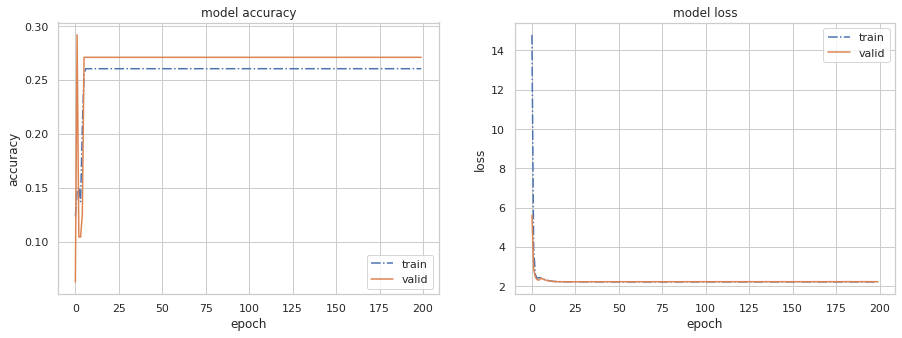

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [ ]:
pred3=model.predict(Xval3)
print(confusion_matrix(np.argmax(yval3,axis=1),
                       np.argmax(pred3,axis=1)))

tf.Tensor(
[[ 0  0  0  0  0  0  1  0  0  0  0  1]
 [ 0  5  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  2  0  2  0  3  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  1  0  2  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  3  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  2  0  0  0  0  2]], shape=(12, 12), dtype=int32)


tf.Tensor(
[[ 0  0  0  0  0  0  1  0  0  0  0  1]
 [ 0  5  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  2  0  2  0  3  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  1  0  2  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  3  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  2  0  0  0  0  2]], shape=(12, 12), dtype=int32)


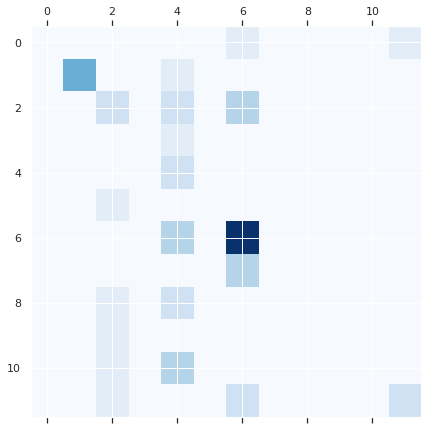

In [ ]:
pred=model.predict(Xval3)
mconfuse=confusion_matrix(np.argmax(yval3,axis=1), np.argmax(pred,axis=1))
plt.matshow(mconfuse, cmap=plt.cm.Blues, alpha=2)
print(mconfuse)

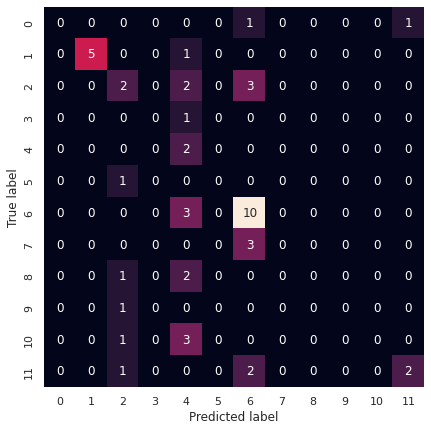

In [ ]:
sns.set(rc = {'figure.figsize':(7,7)})
sns.heatmap(mconfuse, square = True, annot = True, fmt='d', cbar = False)
plt.xlabel('Predicted label')
plt.ylabel('True label');